<h2 style='color:orange' align='center'>Data Cleaning<h2>

In [277]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt
%matplotlib inline

<h3 style='color:blue'>(1) Preprocessing: Detect face, eyes, and crop the facial region of the image.</h3>

In [325]:
img = cv2.imread('./sample_img2.jpg')
img.shape

(1440, 1080, 3)

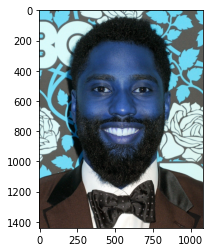

In [326]:
plt.imshow(img)

In [280]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1440, 1080)

In [281]:
gray

array([[217, 214, 210, ..., 214, 214, 213],
       [217, 214, 212, ..., 214, 213, 213],
       [215, 213, 213, ..., 214, 213, 212],
       ...,
       [ 68,  72,  52, ...,  55,  30,  35],
       [ 37,  57,  47, ...,  39,  23,  42],
       [ 30,  52,  56, ...,  34,  43,  28]], dtype=uint8)

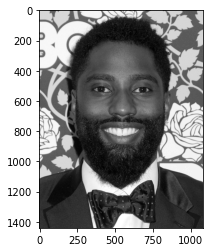

In [282]:
plt.imshow(gray, cmap='gray')

In [283]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[182, 212, 727, 727]])

In [284]:
(x,y,w,h) = faces[0]
x,y,w,h

(182, 212, 727, 727)

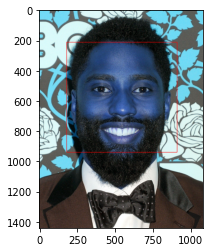

In [285]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

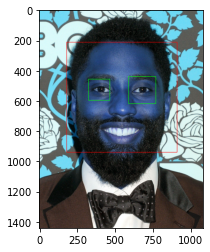

In [286]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

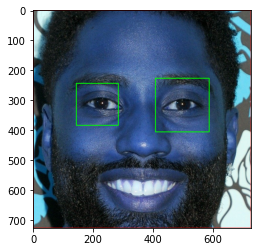

In [287]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [288]:
#Putting the detection of face and eyes into a function. 
# First, load the image and if eyas >= 2, the save and crop the faical region of the image.

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

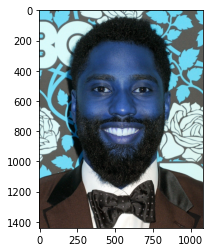

In [289]:
original_image = cv2.imread('./sample_img2.jpg')
plt.imshow(original_image)

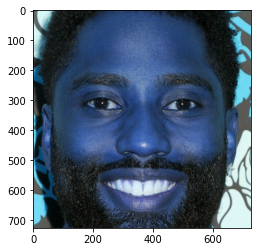

In [290]:
#Crop the facial region of the image

cropped_image = get_cropped_image_if_2_eyes('./sample_img2.jpg')
plt.imshow(cropped_image)

**If the eyes cannot be detected in an image, the ouput of the function will return None.**

None
Eyes cannot be detected in the image


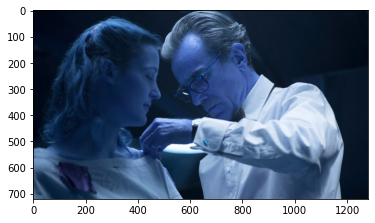

In [291]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./sample.jpg')
print(cropped_image_no_2_eyes)

if cropped_image_no_2_eyes is None:
    print("Eyes cannot be detected in the image")
    plt.imshow(cv2.imread('./sample.jpg'))
    
else:
    print("Success")    


#NOTHING

<h3 style='color:blue'>(2) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose and lips. This along with raw pixel image can be used as an input for classifier.

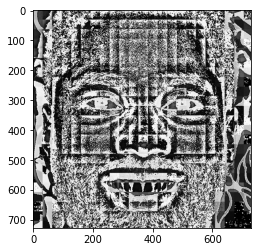

In [292]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

<h3 style='color:blue'>(3) Preprocessing: Go through all images in Image_Scrapping folder and create cropped images. A new cropped folder will be created after this step. </h3>


In [293]:
# Directory to be scanned
path_to_data = "./Image_Scrapping/"
path_to_cr_data = "./Image_Scrapping/cropped/"

In [294]:
import os
img_dirs = []

 
# Scan the directory and get
# an iterator of os.DirEntry objects
# corresponding to entries in it
# using os.scandir() method

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
        
#Get the directories of all the scrapped images        

In [295]:
img_dirs

['./Image_Scrapping/daniel_day_lewis',
 './Image_Scrapping/Emily_Blunt_portrait',
 './Image_Scrapping/John_David_Washington',
 './Image_Scrapping/michelle_yeoh_portrait',
 './Image_Scrapping/saoirse_ronan',
 './Image_Scrapping/tony_leung_portrait']

In [303]:
#Rename the jpg file for each celebrity. 
#Because some file names might contain ambigous unicode character which might cause error for the function get_cropped_image_if_2_eyes()

for img_dir in img_dirs:
   
    celebrity_name = img_dir.split('/')[-1]   #Get the name of the celebrity
    
    i = 1
    
    for filename in os.listdir(img_dir):
        
        image = cv2.imread(img_dir +'/' + filename)
        
        if type(image) is np.ndarray :  #Make sure the file is JPG
            
            os.rename(img_dir +'/' + filename, 
                      img_dir +'/' + celebrity_name + str(i) + ".jpg")
            
        i = i + 1

In [304]:
#Create cropped file

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [305]:

cropped_image_dirs = []
celebrity_file_names_dict = {}

#Iterate through image directories, 

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]   #Get the name of the celebrity
    
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
      
        image = cv2.imread(entry.path)
        
        if type(image) is np.ndarray :  #Make sure the file is JPG
            
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            
            if roi_color is not None:
               cropped_folder = path_to_cr_data + celebrity_name
               
               if not os.path.exists(cropped_folder):             #Create crop folders with the celebrities name
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ",cropped_folder)
                
               cropped_file_name = celebrity_name + str(count) + ".png"
               cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
               cv2.imwrite(cropped_file_path, roi_color)
               celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
               count += 1    
               
               

        


Generating cropped images in folder:  ./Image_Scrapping/cropped/daniel_day_lewis
Generating cropped images in folder:  ./Image_Scrapping/cropped/Emily_Blunt_portrait
Generating cropped images in folder:  ./Image_Scrapping/cropped/John_David_Washington
Generating cropped images in folder:  ./Image_Scrapping/cropped/michelle_yeoh_portrait
Generating cropped images in folder:  ./Image_Scrapping/cropped/saoirse_ronan
Generating cropped images in folder:  ./Image_Scrapping/cropped/tony_leung_portrait


<h3 style='color:blue'>(4) Preprocessing: Manually examine the cropped folders and delete any unwanted images </h3>

## The get_cropped_image_if_2_eyes fucntion will crop any facial region with two eyes. For instance, if there are two persons with clear facial features in an image, the funcion will crop the two faces and save them as two jpg files to the folder. Most likely one of the jpg file is not the targeted celebrity and we have to manually delete the unwanted image.

<h3 style='color:blue'>(5) Preprocessing: Create a dictionary and assign numeric value for each celebrity. </h3>

In [306]:
celebrity_file_names_dict2 = {}

for img_dir in cropped_image_dirs:
    
    celebrity_name = img_dir.split('/')[-1]
    
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict2[celebrity_name] = file_list
        

class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict2.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict



{'daniel_day_lewis': 0,
 'Emily_Blunt_portrait': 1,
 'John_David_Washington': 2,
 'michelle_yeoh_portrait': 3,
 'saoirse_ronan': 4,
 'tony_leung_portrait': 5}

<h3 style='color:blue'>(6) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

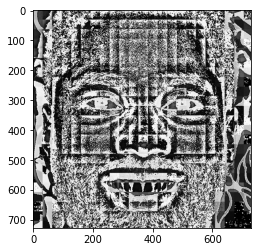

In [307]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')



**Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train the classifier. Let's prepare X and y now.**

In [308]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict2.items():
    for training_image in training_files:
       
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  
        
        
len(X[0])        
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(471, 4096)

<h2 style='color:orange' align='center'>Machine Learning Model<h2>

In [309]:
#We will use SVM with rbf kernel tuned  with heuristic finetuning

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import seaborn as sn

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.711864406779661

In [311]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.63      0.91      0.75        34
           2       0.73      0.80      0.76        10
           3       0.75      0.40      0.52        15
           4       0.84      0.62      0.71        26
           5       0.72      0.75      0.73        24

    accuracy                           0.71       118
   macro avg       0.75      0.67      0.69       118
weighted avg       0.73      0.71      0.70       118



### Use GridSearch to try out different models with different paramets. The goal is to come up with best model with best fine tuned parameters.

In [312]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}


scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.739396,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.518431,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.705272,{'logisticregression__C': 1}


In [313]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [314]:
dict = {best_estimators['svm']: best_estimators['svm'].score(X_test,y_test),
        best_estimators['random_forest']: best_estimators['random_forest'].score(X_test,y_test),
        best_estimators['logistic_regression']: best_estimators['logistic_regression'].score(X_test,y_test)}

**To get the best model**

In [318]:
best_clf = max(dict, key=dict.get)

## Confusion Matrix

In [319]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 8,  0,  1,  0,  0,  0],
       [ 1, 26,  1,  3,  2,  1],
       [ 0,  0,  9,  0,  0,  1],
       [ 1,  2,  0, 10,  0,  2],
       [ 1,  3,  0,  1, 21,  0],
       [ 0,  1,  5,  2,  0, 16]], dtype=int64)

Text(69.0, 0.5, 'Truth')

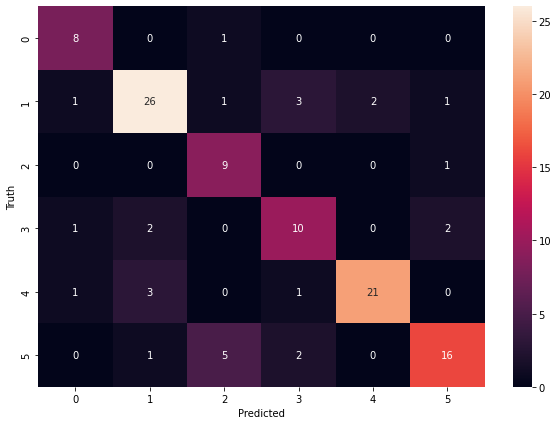

In [320]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Based on the visualization, we can see that 8 out of 11 attempts the model correctly predicted the images of Daniel Day Lewis. The model made three mistakes that misidentify Daniel Day Lewis as Emily Blunt(1), Michelle Yeoh(3), and Saoirse Ronan(4).**

In [321]:
class_dict

{'daniel_day_lewis': 0,
 'Emily_Blunt_portrait': 1,
 'John_David_Washington': 2,
 'michelle_yeoh_portrait': 3,
 'saoirse_ronan': 4,
 'tony_leung_portrait': 5}

## Create a function to classify an upload image.

In [322]:
def classify_image(image_path):
  
    ans = []

    img = get_cropped_image_if_2_eyes(image_path)
    
    if img is None:
       print("Eyes cannot be detected in the image")
       plt.imshow(cv2.imread('./sample.jpg'))
      
    
    else:
          
      scalled_raw_img = cv2.resize(img, (32, 32))
      img_har = w2d(img, 'db1', 5)
      scalled_img_har = cv2.resize(img_har, (32, 32))
      combined_img = np.vstack((scalled_raw_img.reshape(32 * 32 * 3, 1), scalled_img_har.reshape(32 * 32, 1)))

      len_image_array = 32*32*3 + 32*32
      final = combined_img.reshape(1,len_image_array).astype(float)
    
      result = best_clf.predict(final) 
      if result == 0:
          ans.append({"class": "Daniel Day Lewis",
                    "class_probability": np.around(best_clf.predict_proba(final)*100,2).tolist()[0],
                     "class_dictionary": class_dict
                       })
        
      elif result == 1:
       
        ans.append({"class":"Emily Blunt",
                    "class_probability": np.around(best_clf.predict_proba(final)*100,2).tolist()[0],
                     "class_dictionary": class_dict
                       })
        
      elif result == 2:
        
        ans.append({"class":"John David Washington",
                    "class_probability": np.around(best_clf.predict_proba(final)*100,2).tolist()[0],
                     "class_dictionary": class_dict
                       })
        
      elif result == 3:
        
        ans.append({
                     "class":"Michelle Yeoh",
                     "class_probability": np.around(best_clf.predict_proba(final)*100,2).tolist()[0],
                     "class_dictionary": class_dict
                       })
        
      elif result == 4:   
        ans.append("Saoirse Ronan")
        ans.append({
                     "class":"Saoirse Ronan",
                     "class_probability": np.around(best_clf.predict_proba(final)*100,2).tolist()[0],
                     "class_dictionary": class_dict
                       })
        
      elif result == 5:   
        
        ans.append({
                     "class":"Tony Leung",
                     "class_probability": np.around(best_clf.predict_proba(final)*100,2).tolist()[0],
                     "class_dictionary": class_dict
                       })    
        
    return ans

## Insert the file link into the fuction to classify the image, make sure the file type is jpg. Try changing the file name if an error is received.

In [323]:
ans = classify_image("C:/Users/hp/Desktop/Github/Image Classification/sample_img2.jpg")
ans

[{'class': 'John David Washington',
  'class_probability': [1.35, 0.42, 92.15, 5.52, 0.17, 0.41],
  'class_dictionary': {'daniel_day_lewis': 0,
   'Emily_Blunt_portrait': 1,
   'John_David_Washington': 2,
   'michelle_yeoh_portrait': 3,
   'saoirse_ronan': 4,
   'tony_leung_portrait': 5}}]

**The output shows the prediction based on the image uploaded, and returns the class probabilities for each data point.**